# MLADHD Experiment notebook

Notebook created by [Gonzalo Córdova](https://github.com/gonzalo-cordova-pou) in January 2023. (Last update: March 2023)

For any doubts: gonzalo.cordova@estudiantat.upc.edu

## Content:
- [Setting up the enviroment](#s1)
- [Creating a new model](#s2)
- [Training the model](#s3)
- [Testing our model](#s4)
- [Using the model](#s5)
- [Wrong predictions analysis](#s6)

<a name='s1'></a>
## Setting up our Local enviroment

We import Python packages:

In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import random
import torch
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import sampler, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from codecarbon import EmissionsTracker
import matplotlib.pyplot as plt
import time
import os
import ipyplot

We clone [our GitHub repo](https://github.com/JulianaGSouza/MLADHD) to the enviroment. Make sure that you have access to the repository.

Finally import our MLADHD module.

In [2]:
from mlmodeling import *

Using cuda device


<a name='s2'></a>
## Setting up the Mlflow Experiment Tracking

In [3]:
from mlflow import log_metric, log_param, log_artifacts

In [4]:
mlflow.set_experiment(experiment_name="MLADHD_Experiments")

<Experiment: artifact_location='file:///E:/mladhd/MLADHD/mlruns/171971568197065632', creation_time=1679508626395, experiment_id='171971568197065632', last_update_time=1679508626395, lifecycle_stage='active', name='MLADHD_Experiments', tags={}>

In [5]:
mlflow.start_run()

<ActiveRun: >

<a name='s2'></a>
## Create a new model

The idea of case 1 is to create a model by using a pretrained PyTorch model and adding a classification layer. We will train the model freezing the pretrained model (resnet50, in this case).

- Choose a name for the model
- Indicate where the data is stored
- Choose where to save the model
- Choose a validation size

**IMPORTANT** Make sure that the model_dir exists, create the folder if necessary

In [6]:
model_name = 'model_with_extended_dataset'
data_dir = 'E:\\mladhd\\datasets\\data_clean_extended\\'
models_dir = 'E:\\mladhd\\models\\'
split = (0.7, 0.15, 0.15)

In [7]:
mlflow.log_param("model_name", model_name)
mlflow.log_param("data_dir", data_dir)
mlflow.log_param("data_split", split)

(0.7, 0.15, 0.15)

Create a dictionary with the hyperparameters:

In [8]:
hyperparams = {
    'lr': 0.001, 
    'epochs': 3, 
    'batch_size': 128,
    'optimizer': 'Adam',            # options: Adam, SGD
    'loss': 'NLLLoss',              # options: NLLLoss, CrossEntropyLoss
    'pretrained_model': 'resnet50', # options: resnet50, vgg16
    'freeze_pretrained_model': False,# options: True, False
    'train_transforms': 'default',  # options: default
    'valid_transforms': 'default',    # options: default
    'test_transforms': 'default'    # options: default
}

Create a new experiment with the MLADHD Python class.

In [9]:
experiment = MLADHD(model_name, data_dir, models_dir, hyperparams)

Log hyperparams in mlflow

In [10]:
mlflow.log_params(experiment.hyperparams)

Load and split the data into train and test.

In [11]:
experiment.load_split_dataset(split)

Train size:  2976
Valid size:  637
Test size:  639


In [12]:
total_len = len(experiment.trainloader.dataset) + len(experiment.validloader.dataset) + len(experiment.testloader.dataset)
mlflow.log_param("Total dataset size", total_len)
mlflow.log_param("Train size", len(experiment.trainloader.dataset))
mlflow.log_param("Valid size", len(experiment.validloader.dataset))
mlflow.log_param("Test size", len(experiment.testloader.dataset))

639

Create a new model using the pretrained model indicated in the hyperparameters

In [13]:
experiment.create_model()

Check what pretrained model has been used.

In [14]:
experiment.hyperparams["pretrained_model"]

'resnet50'

<a name='s3'></a>
## Training the model

Now lets train our model with the train data:

In [15]:
tracker = EmissionsTracker()
tracker.start()

In [16]:
start_time = time.time()
experiment.train_model()
dur = (time.time() - start_time)/60
print(f"Total time: {dur} minutes")
mlflow.log_param("Training_time_min", dur)

Epoch: 1/3
Batch number: 000/024, Training: Loss: 0.6925, Accuracy: 0.5156
Batch number: 005/024, Training: Loss: 0.1908, Accuracy: 0.9062
Batch number: 010/024, Training: Loss: 0.0297, Accuracy: 0.9922
Batch number: 015/024, Training: Loss: 0.0275, Accuracy: 0.9922
Batch number: 020/024, Training: Loss: 0.0234, Accuracy: 0.9844
Valid. Batch number: 000/005, Valid: Loss: 0.6656, Accuracy: 0.9688
Valid. Batch number: 001/005, Valid: Loss: 0.3256, Accuracy: 0.9375
Valid. Batch number: 002/005, Valid: Loss: 0.4296, Accuracy: 0.9531
Valid. Batch number: 003/005, Valid: Loss: 0.4984, Accuracy: 0.9609
Valid. Batch number: 004/005, Valid: Loss: 0.8078, Accuracy: 0.9360
__________
Epoch : 001
Training: Loss: 0.1542, Accuracy: 0.9315
Validation: Loss: 0.5442, Accuracy: 0.9513
__________
Epoch: 2/3
Batch number: 000/024, Training: Loss: 0.0122, Accuracy: 1.0000
Batch number: 005/024, Training: Loss: 0.0215, Accuracy: 0.9922
Batch number: 010/024, Training: Loss: 0.0077, Accuracy: 1.0000
Batch nu

E:\Users\ADHD Project\anaconda3\envs\env_mladhd\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'model_with_extended_dataset_resnet50_2023-03-27_16-08-23'.
2023/03/27 16:20:42 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: model_with_extended_dataset_resnet50_2023-03-27_16-08-23, version 1


Total time: 12.162016669909159 minutes


Created version '1' of model 'model_with_extended_dataset_resnet50_2023-03-27_16-08-23'.


12.162016669909159

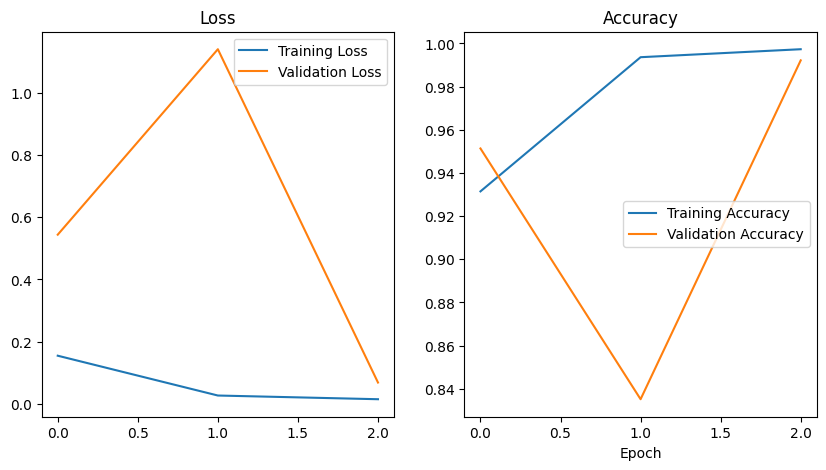

In [17]:
experiment.plot_training()

Check that the new trained model and the hyperparameters used have been stored in the indicated folder with the name *modelname_pretrainedmodel_date_time.pth* and *modelname_pretrainedmodel_date_time.json* respectively.

<a name='s4'></a>
## Test the model

Now lets test our model with the test data and see the test_loss, accuracy, precision, recall and F1-Score.

Testing model...
Test Batch number: 000, Test: Loss: 0.0011, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Test Batch number: 001, Test: Loss: 0.0563, Accuracy: 0.9844, Precision: 0.9850, Recall: 0.9844, F1 Score: 0.9844
Test Batch number: 002, Test: Loss: 0.0115, Accuracy: 0.9922, Precision: 0.9923, Recall: 0.9922, F1 Score: 0.9922
Test Batch number: 003, Test: Loss: 0.0255, Accuracy: 0.9844, Precision: 0.9851, Recall: 0.9844, F1 Score: 0.9845
Test Batch number: 004, Test: Loss: 0.0006, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Test: Loss: 0.0190, Accuracy: 99.2175%, Precision: 99.2467%, Recall: 99.2175%, F1 Score: 99.2206%


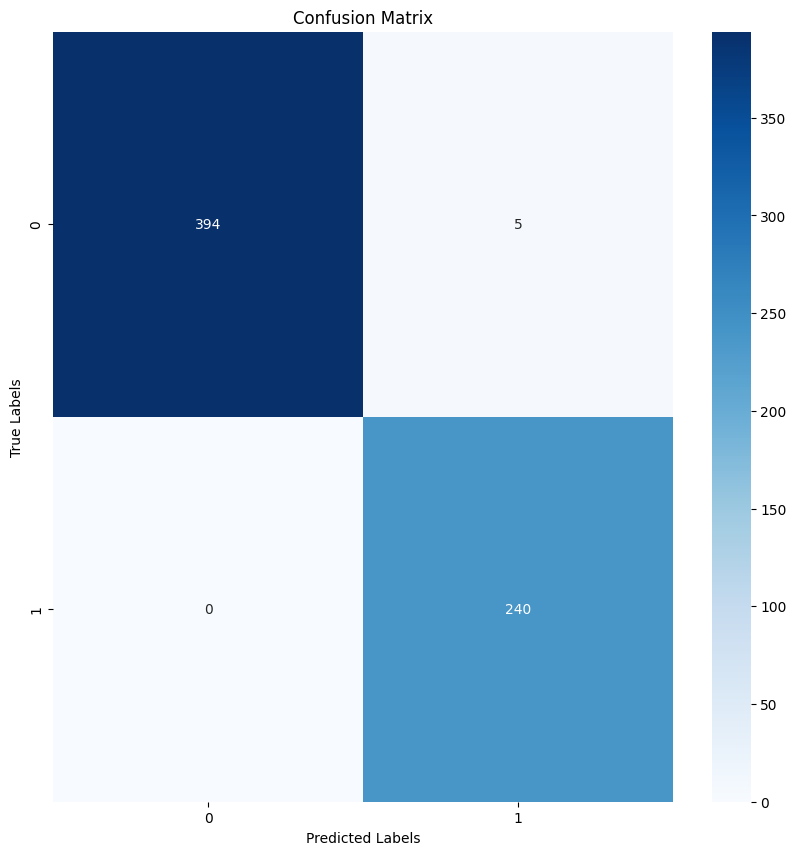

In [18]:
print("Testing model...")
experiment.test_model()

In [19]:
emissions: float = tracker.stop()
print("Emissions:", emissions)
mlflow.log_metric("Emissions", emissions)

Emissions: 0.01846482289036316


In [20]:
mlflow.end_run()

<a name='s5'></a>
## Using the model

If we have already trained a model we can load it to our enviroment in order to new predictions
We will load:
- The trained model
- The hyperparameters used for its training

In [23]:
data_dir = 'E:\\mladhd\\datasets\\data_clean_extended\\'
models_dir = 'E:\\mladhd\\models\\'
pretrained_model = 'model_with_extended_dataset_resnet50_2023-03-27_16-08-23'
model_name = pretrained_model.split('_')[0]
print("Loading hyperparams...")
with open(models_dir+pretrained_model+'.json', 'r') as fp:
    hyperparams = json.load(fp)
# when loading a pretrained model, the date is updated to the current date
# so that the model is not overwritten (see __init__)
experiment2 = MLADHD(model_name, data_dir, models_dir, hyperparams)
experiment2.load_model(os.path.join(models_dir,  pretrained_model + '.pth'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
experiment2.model = experiment2.model.to(device)

Loading hyperparams...
Model loaded from:  E:\mladhd\models\model_with_extended_dataset_resnet50_2023-03-27_16-08-23.pth


In [24]:
experiment2.hyperparams

{'lr': 0.001,
 'epochs': 3,
 'batch_size': 128,
 'optimizer': 'Adam',
 'loss': 'NLLLoss',
 'pretrained_model': 'resnet50',
 'freeze_pretrained_model': False,
 'train_transforms': 'default',
 'valid_transforms': 'default',
 'test_transforms': 'default'}

### One image prediction

In [25]:
label, pred, prob = experiment2.predict("E:\\mladhd\\datasets\\data_clean_extended\\1_distracted\\distracted_amazon_one_13.jpg")
print("Real class: ", label)
print("Predicted class: ", pred, "[p =", prob, "]")

Real class:  distracted
Predicted class:  distracted [p = 1.0 ]


### N random images prediction

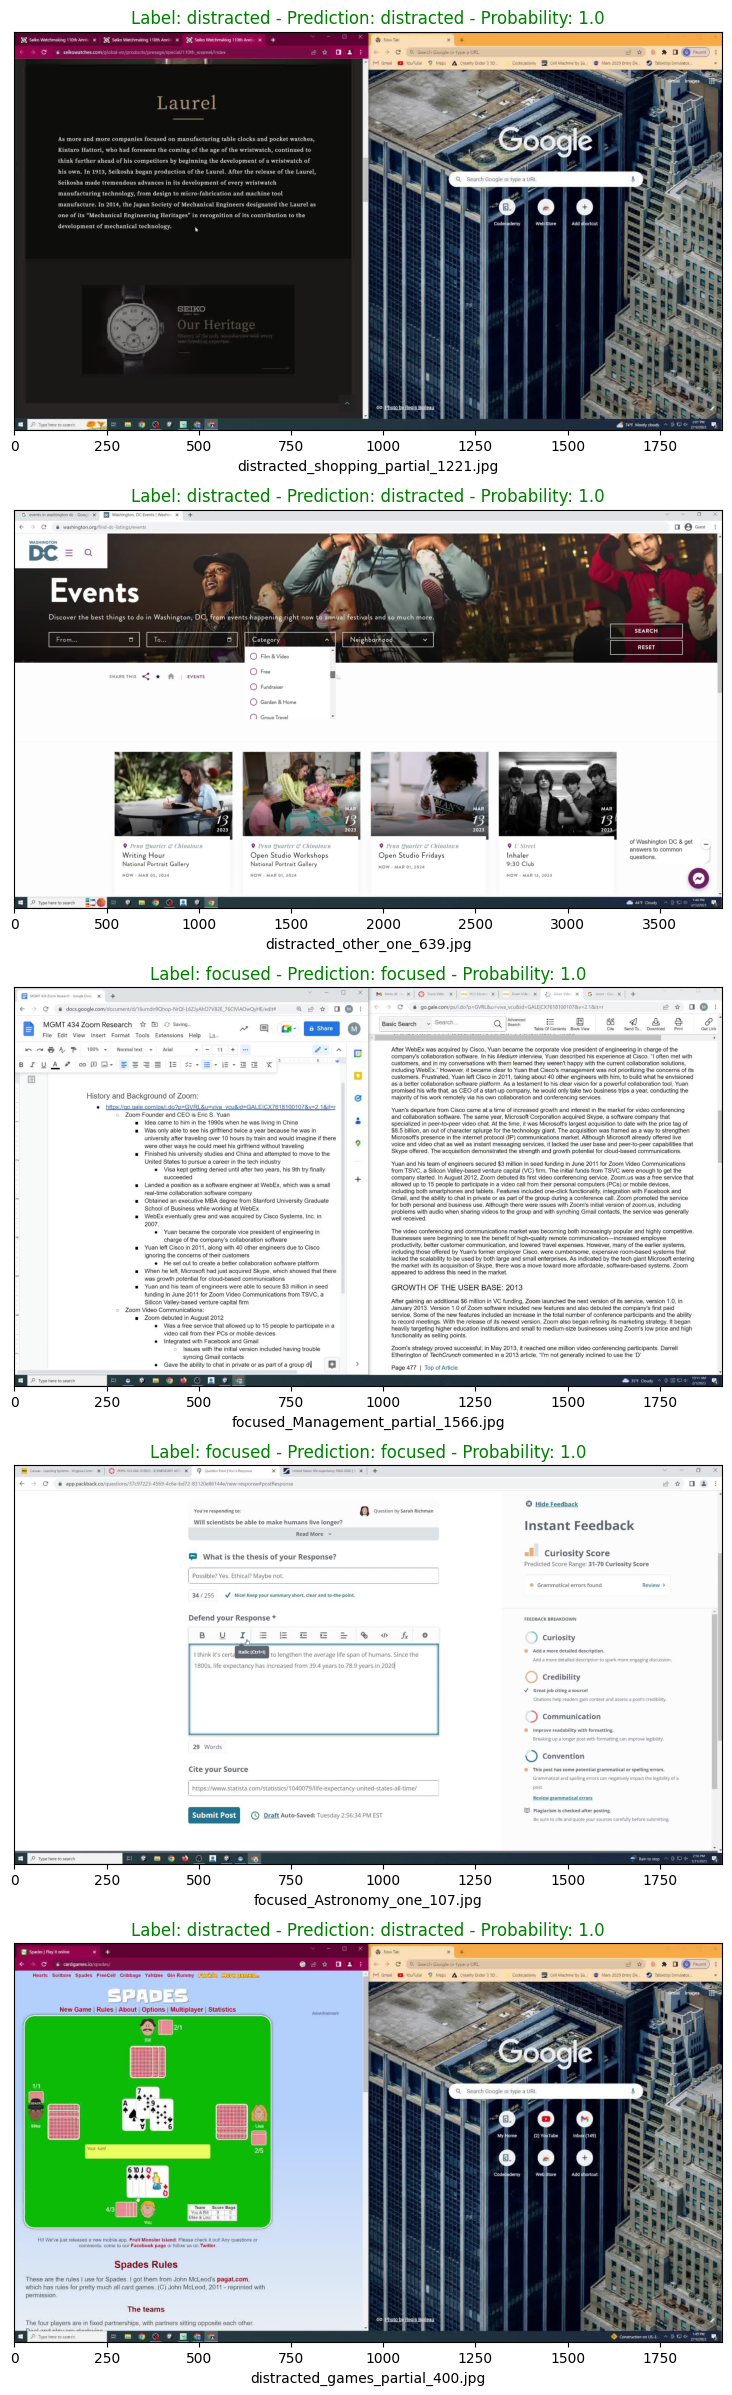

In [26]:
experiment2.test_random_images(data_dir, 5)

<a name='s6'></a>
## Wrong predictions analysis

In [27]:
errors_focused = []
errors_distracted = []
probs = []
p_list = [
    "E:\\mladhd\\datasets\\data_clean_extended\\0_focused",
    "E:\\mladhd\\datasets\\data_clean_extended\\1_distracted"
]
for p in p_list:
    for filename in os.listdir(p):
        f = os.path.join(p, filename)
        # checking if it is a file
        if os.path.isfile(f):
            label, pred, prob = experiment2.predict(f)
            if label != pred:
                probs.append(prob)
                if os.path.basename(p) == "0_focused":
                    errors_focused.append(os.path.join(p,filename))
                if os.path.basename(p) == "1_distracted":
                    errors_distracted.append(os.path.join(p,filename))

In [28]:
len(probs)

27

In [29]:
len(errors_focused)

25

In [30]:
len(errors_distracted)

2

In [31]:
images = errors_focused + errors_distracted
labels = ["focused"]*len(errors_focused) + ["distracted"]*len(errors_distracted)

In [32]:
images

['E:\\mladhd\\datasets\\data_clean_extended\\0_focused\\focused_Data Analytics_one_551.jpg',
 'E:\\mladhd\\datasets\\data_clean_extended\\0_focused\\focused_Data Analytics_partial_584.jpg',
 'E:\\mladhd\\datasets\\data_clean_extended\\0_focused\\focused_Literature_one_1221.jpg',
 'E:\\mladhd\\datasets\\data_clean_extended\\0_focused\\focused_Literature_one_1222.jpg',
 'E:\\mladhd\\datasets\\data_clean_extended\\0_focused\\focused_Literature_one_1225.jpg',
 'E:\\mladhd\\datasets\\data_clean_extended\\0_focused\\focused_Management_partial_1534.jpg',
 'E:\\mladhd\\datasets\\data_clean_extended\\0_focused\\focused_Management_partial_1643.jpg',
 'E:\\mladhd\\datasets\\data_clean_extended\\0_focused\\focused_Management_partial_1648.jpg',
 'E:\\mladhd\\datasets\\data_clean_extended\\0_focused\\focused_other_partial_1743.jpg',
 'E:\\mladhd\\datasets\\data_clean_extended\\0_focused\\focused_other_partial_1749.jpg',
 'E:\\mladhd\\datasets\\data_clean_extended\\0_focused\\focused_other_partial_17

Real label: focused
Probability of real label 0.009999990463256836


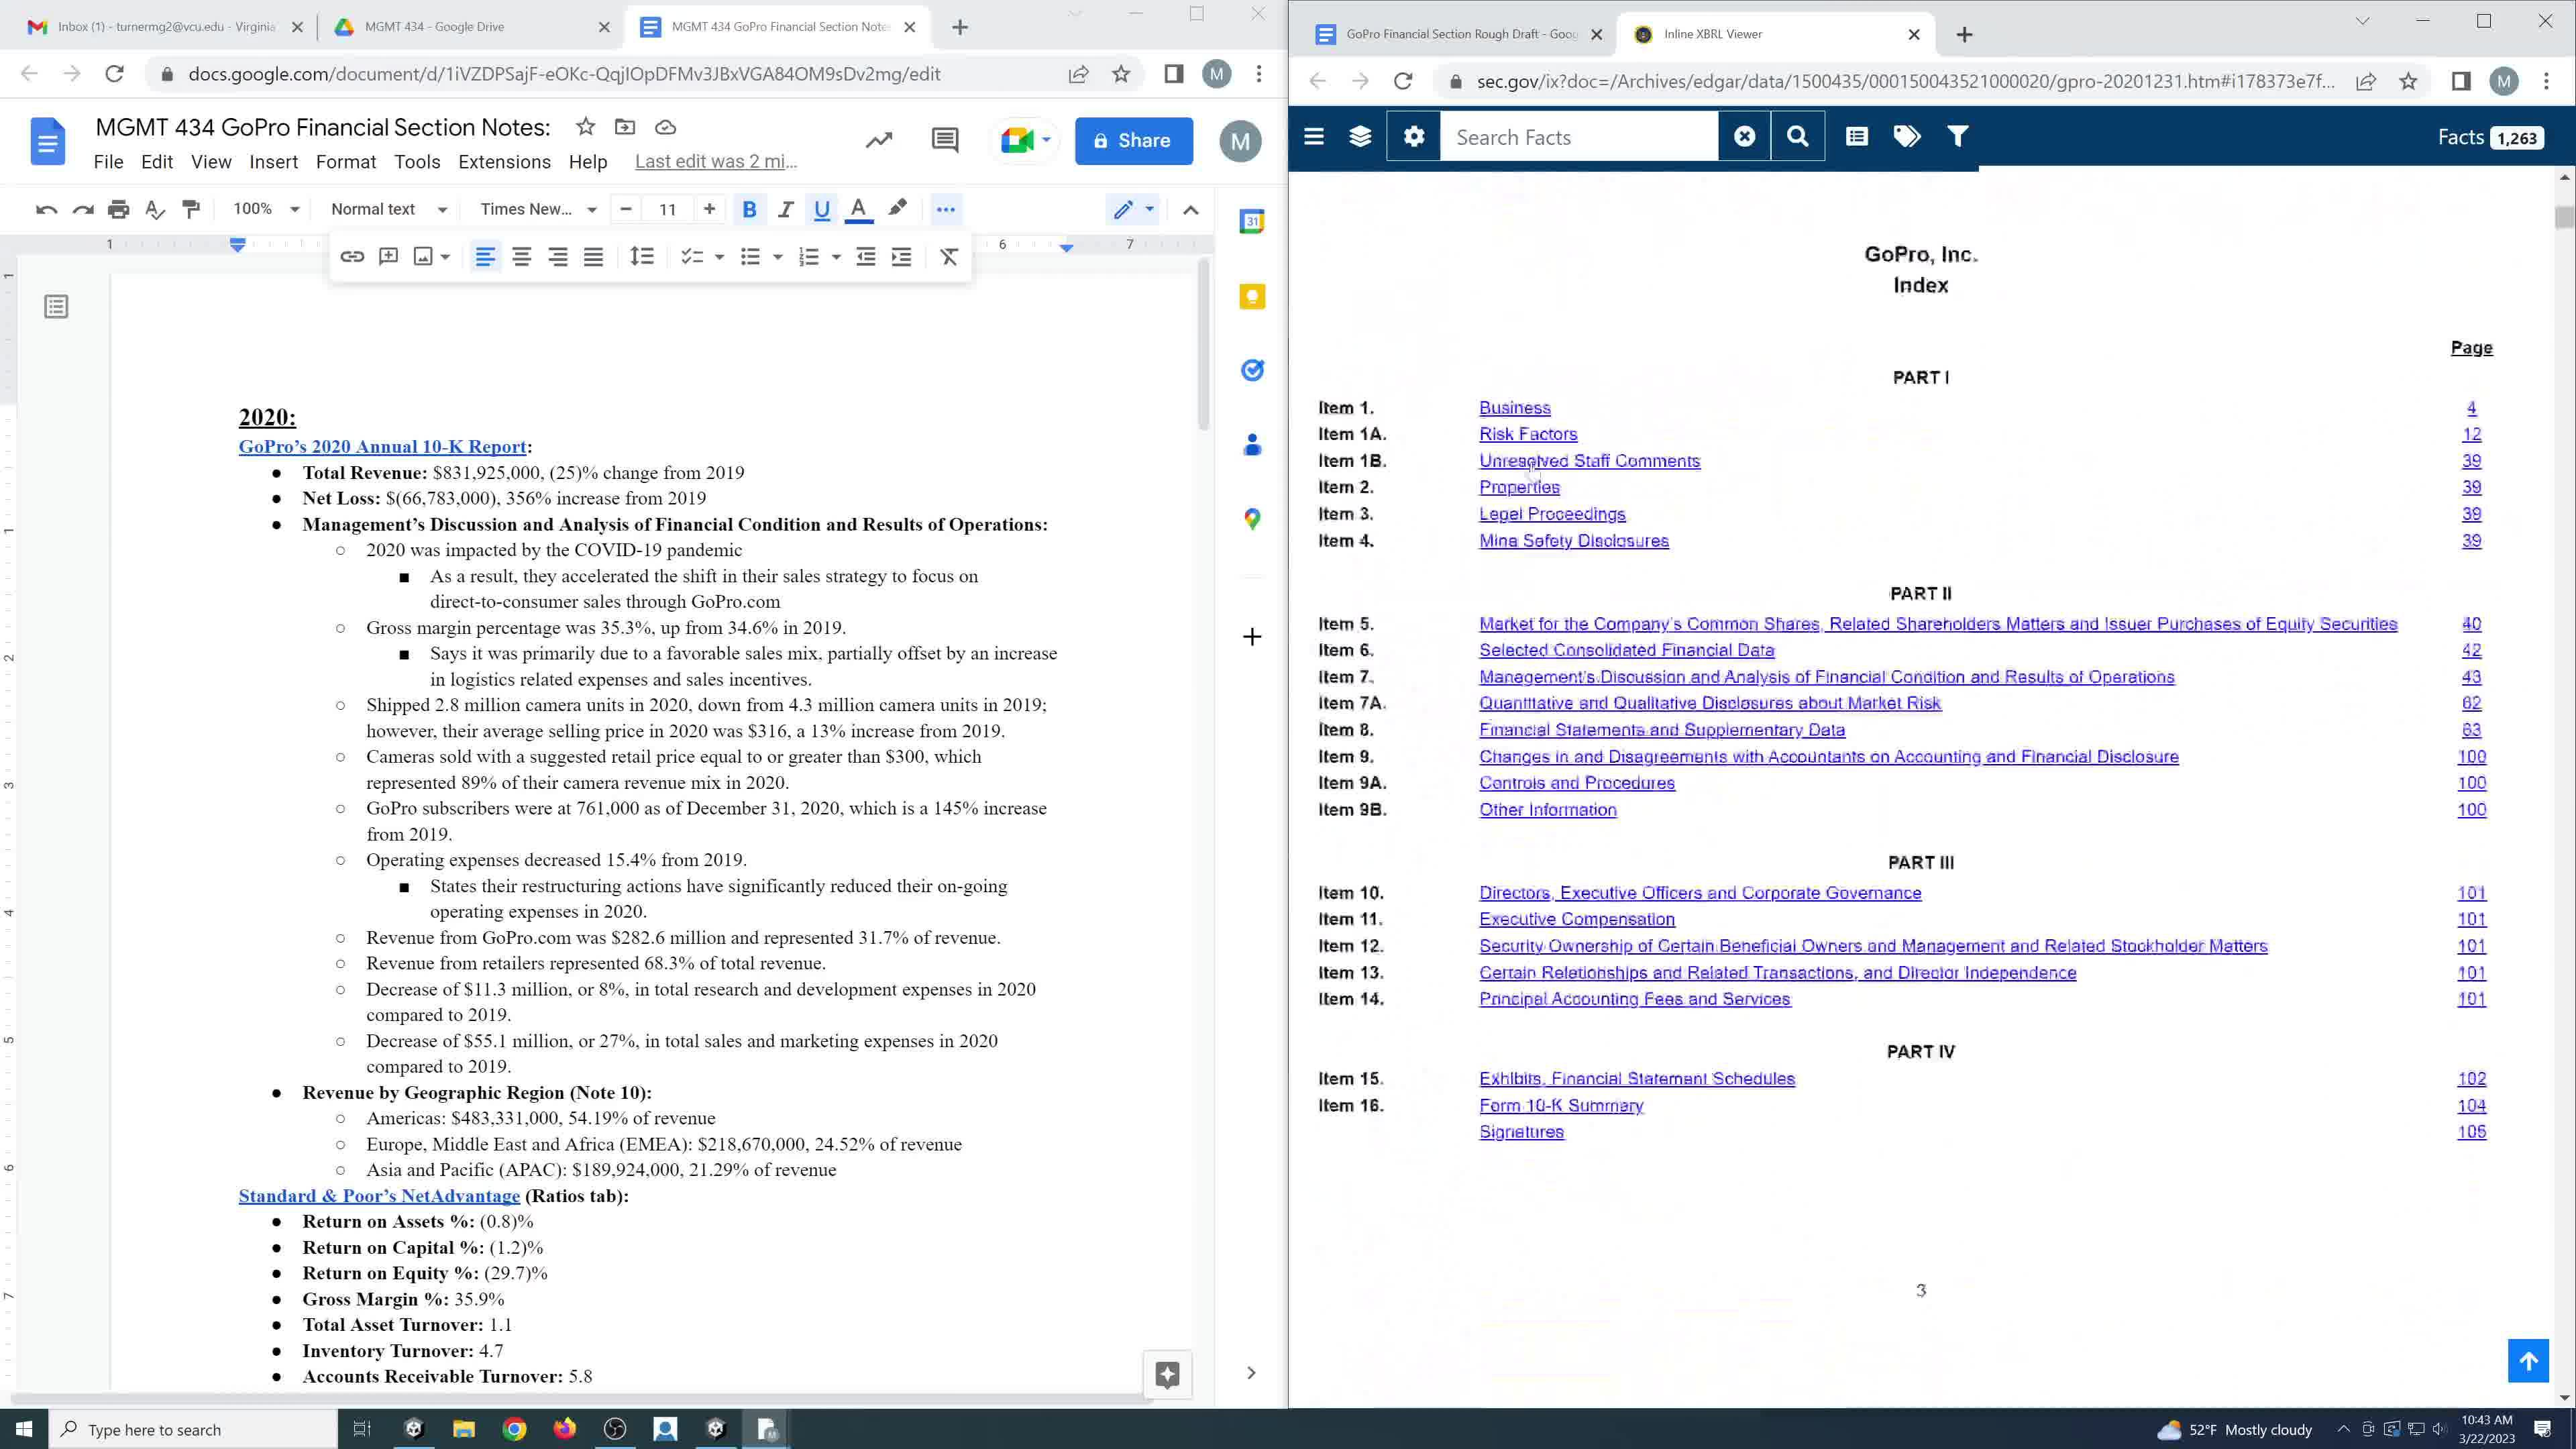

In [38]:
from IPython.display import Image
i = random.choice(range(0, len(images)))
print("Real label:", labels[i])
print("Probability of real label", 1-probs[i])
Image(filename=images[i])